In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import random

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
A = np.linspace(0.62, 0.63, 101)
csv_paths = [(f"data/output_{a}.csv") for a in A]

In [ ]:

compile_cmd = "g++ sim.cpp"
subprocess.run(compile_cmd, shell=True, check=True)
subprocess.run("mkdir -p data", shell=True, check=True)
subprocess.run("mkdir -p plots", shell=True, check=True)

for a in A:
    subprocess.run(f"./a.out {a}", shell=True, check=True)

In [3]:
def AppendLocalOptima(csv_path, stabilizing_time, window_size):
    df = pd.read_csv(csv_path)
    df = df.iloc[stabilizing_time:]

    # the first window size values will also be nan because of how pandas rolling max works

    rolling_max = df['u'].rolling(2 * window_size+ 1, center=True).max()
    rolling_min = df['u'].rolling(2 * window_size+ 1, center=True).min()

    df['is_local_opt'] = (df['u'] == rolling_max) | (df['u'] == rolling_min)
    return df

stabilizing_time = 20000
window_size = 1

timeseries_dataframes = [AppendLocalOptima(csv_path, stabilizing_time, window_size) for csv_path in csv_paths]
print(timeseries_dataframes[0])


           time        u        v  is_local_opt
20000    200.00 -1.74807 -1.19414         False
20001    200.01 -1.75199 -1.19424         False
20002    200.02 -1.75586 -1.19433         False
20003    200.03 -1.75968 -1.19444         False
20004    200.04 -1.76344 -1.19454         False
...         ...      ...      ...           ...
999995  9999.95 -2.21778 -1.32241         False
999996  9999.96 -2.21641 -1.32287         False
999997  9999.97 -2.21502 -1.32333         False
999998  9999.98 -2.21361 -1.32378         False
999999  9999.99 -2.21216 -1.32424         False

[980000 rows x 4 columns]


In [5]:
def PlotExtrema(df, a): 
    plt.figure(figsize=(12, 6))

    mean_u = df['u'].mean()
    std_u = df['u'].std()

    plt.subplot(2, 1, 1)
    plt.plot(df['time'], df['u'], label='u(t)')
    plt.title(f'u trajectory over time, A = {a}')
    plt.xlabel('Time')
    plt.ylabel('u')

    # Plot local optima
    plt.scatter(
        df.loc[df['is_local_opt'], 'time'],
        df.loc[df['is_local_opt'], 'u'],
        color='red', marker='o', label='Local Optima', zorder=3
    )

    # Plot mean and ±6 std lines
    plt.axhline(mean_u, color='green', linestyle='--', label='Mean')
    plt.axhline(mean_u + 6 * std_u, color='orange', linestyle='--', label='Mean ± 6σ')
    plt.axhline(mean_u - 6 * std_u, color='orange', linestyle='--')

    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df['time'], df['v'])
    plt.title(f'v trajectory over time, A = {a}')
    plt.xlabel('Time')
    plt.ylabel('v')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'plots/extrema_{a}.png')
    return

# for a,df in zip(A, timeseries_dataframes):
#     PlotExtrema(df, a)


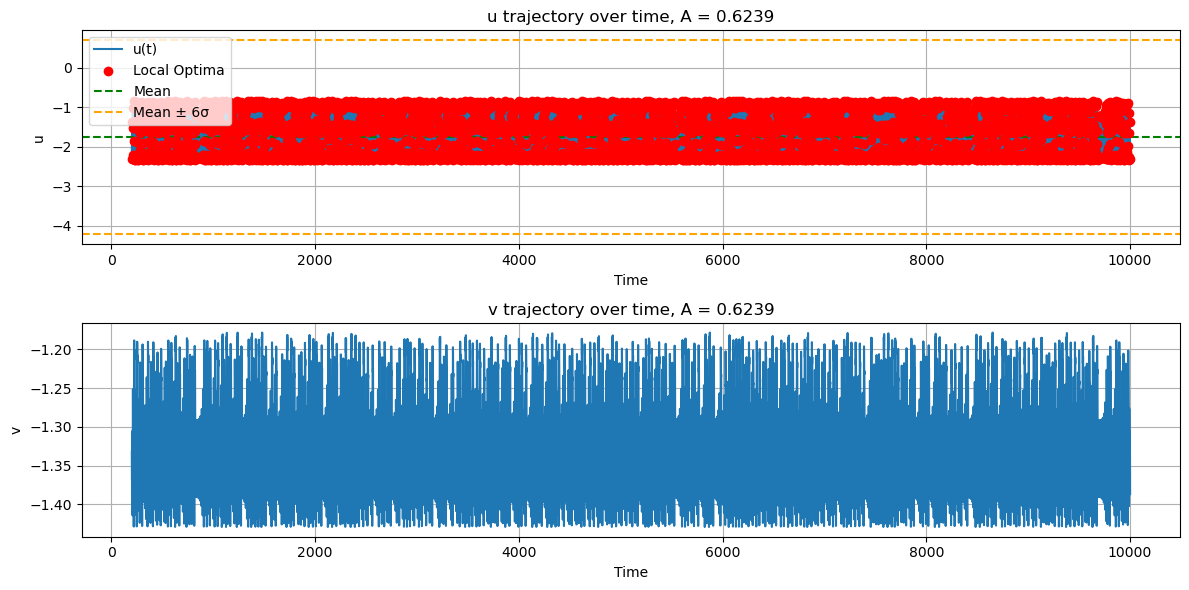

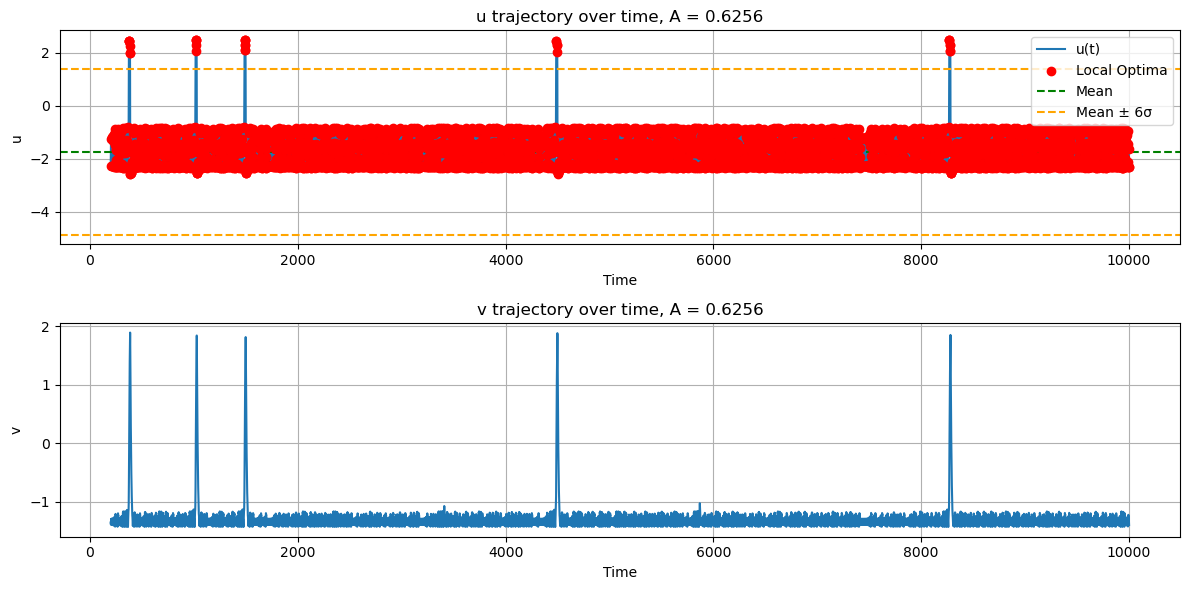

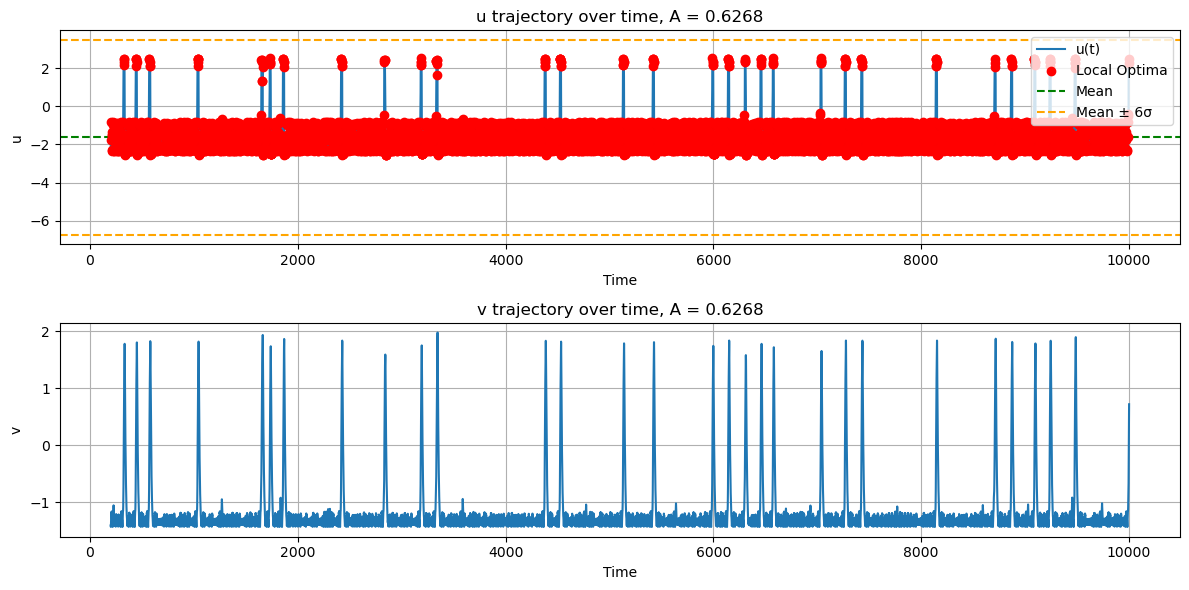

In [7]:

def process_timeseries(A, timeseries_dataframes, mode='all', n=None, subset=None):
    """
    Parameters:
    - A: list of identifiers (same length as timeseries_dataframes)
    - timeseries_dataframes: list of DataFrames corresponding to A
    - mode: 'all', 'random', or 'subset'
    - n: number of samples to select (used if mode == 'random')
    - subset: list of values to use from A (used if mode == 'subset')
    """

    # Convert to list of tuples for easier handling
    data_pairs = list(zip(A, timeseries_dataframes))

    if mode == 'all':
        selected = data_pairs

    elif mode == 'random':
        if n is None:
            raise ValueError("You must specify 'n' when using mode='random'")
        if n > len(A):
            raise ValueError(f"n={n} is greater than number of available elements={len(A)}")
        selected = random.sample(data_pairs, n)

    elif mode == 'subset':
        if subset is None:
            raise ValueError("You must provide a subset list when using mode='subset'")
        # Keep only those entries where a ∈ subset
        selected = [pair for pair in data_pairs if pair[0] in subset]

    else:
        raise ValueError("mode must be one of: 'all', 'random', or 'subset'")

    for a, df in selected:
        PlotExtrema(df, a)

process_timeseries(A, timeseries_dataframes, mode='subset', subset=[0.6239, 0.6256, 0.6268])


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_final = pd.DataFrame()

# Collect all local optima in a single list
all_peak_data = []

for a, df in zip(A, timeseries_dataframes):
    # Extract local optima for this 'a'
    peak_values = df["u"][df["is_local_opt"]]
    for val in peak_values:
        all_peak_data.append({'A': a, 'u_peak': val})

# Convert to DataFrame
peak_df = pd.DataFrame(all_peak_data)

# Plot
plt.figure(figsize=(8, 6))
for a in sorted(peak_df['A'].unique()):
    peaks = peak_df[peak_df['A'] == a]['u_peak']
    x_vals = [a] * len(peaks)
    plt.scatter(x_vals, peaks, label=f"A = {a}", alpha=0.7)

plt.xlabel("A value")
plt.ylabel("Local optima of u")
plt.title("Local Optima for Different Values of A")
plt.grid(True)
plt.show()
